# DSA5201X Project: Stroke Prediction
Name: Cai Bowen  
Student Number: A0236104U

## Project Description

### 1. Data Set
The data set is downloaded [here](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset).  
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.  
The data set provides information about the patients like gender, age, various diseases, smoking status, and whether the patient get stroke.

### 2. Goal
- Use the information of patients to predict whether a patient is likely to get stroke.
- Find which parameter contributes to stroke, so that we can adjust our lifestyle to avoid getting stroke.

## Content
1. [Importing Packages and Data](#1.-Importing-Packages-and-Data)

## 1. Importing Packages and Data

Import the packages used in the analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sampling
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
# preprocessing
from sklearn.preprocessing import MinMaxScaler
# cross validation
from sklearn.model_selection import GridSearchCV
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# model evaluation
from sklearn.metrics import classification_report, plot_roc_curve

Import the data

In [65]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Check the data size

In [4]:
df.shape

(5110, 12)

Check if there are empty values

In [5]:
df.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

## 2. Exploratory Data Analysis
In this part, I will visualize the correlation between each paramater with the target column, in order to find some patterns.

### 2.1 Stroke (the Output)
First, let's check distribution of the output column "stroke".  
From the plot, we can see that the stroke distribution is imbalanced, only about 5% of the data is stroke.
We need to deal with the imbalanced data in data preprocessing.

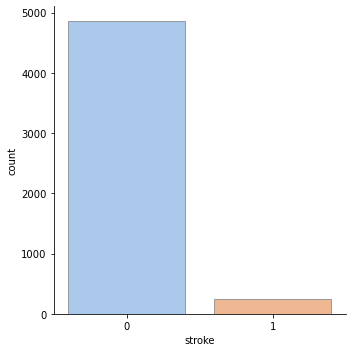

In [6]:
sns.catplot(x='stroke', kind='count', palette='pastel', edgecolor='.6', data=df)

In [7]:
stroke_counts = df['stroke'].value_counts()
print(f'The proportion of stroke: {stroke_counts[1]/stroke_counts.sum(): .2%}')

The proportion of stroke:  4.87%


### 2.2 Gender

There is 1 record with "Other" gender. Consider to drop it.

In [8]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
df = df[df['gender'] != 'Other']

Now check the correlation between gender and stroke. Use confusion matrix to get the proportion of stroke in each gender.  
There is no significant difference between male and female in getting stroke.

In [10]:
pd.crosstab(df['gender'], df['stroke'], normalize='index').round(2)

stroke,0,1
gender,,
Female,0.95,0.05
Male,0.95,0.05


### 2.3 Age

The distribution of age is nearly even. Age of 40-60 has slightly more records.

<AxesSubplot:xlabel='age', ylabel='Count'>

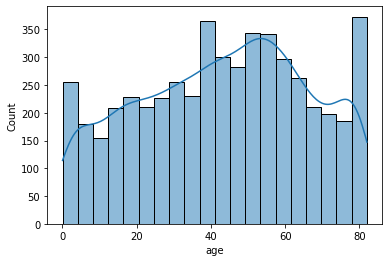

In [11]:
sns.histplot(x='age', data=df, bins=20, kde=True)

From the plot, we can tell that starting from age of 40, older people have higher probability of getting stroke.

<AxesSubplot:xlabel='age', ylabel='Proportion of Stroke'>

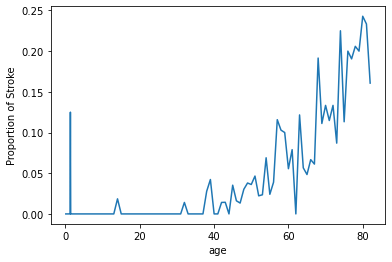

In [78]:
df.groupby('age').mean()['stroke'].plot(ylabel='Proportion of Stroke')

### 2.4 Hypertension

About 10% of records have hypertension

In [13]:
hyp_ten_counts = df['hypertension'].value_counts()
print(f'The proportion of hypertension: {hyp_ten_counts[1]/hyp_ten_counts.sum(): .2%}')

The proportion of hypertension:  9.75%


From the confusion matrix, we can tell that people with hypertension are more likely to get a stroke.

In [14]:
pd.crosstab(df['hypertension'], df['stroke'], normalize='index').round(2)

stroke,0,1
hypertension,,
0,0.96,0.04
1,0.87,0.13


### 2.5 Heart Disease

About 5% of records have heart disease.

In [15]:
hrt_dis_counts = df['heart_disease'].value_counts()
print(f'The proportion of heart disease: {hrt_dis_counts[1]/hrt_dis_counts.sum(): .2%}')

The proportion of heart disease:  5.40%


We can also find that people with heart disease are more likely to get a stroke.

In [16]:
pd.crosstab(df['heart_disease'], df['stroke'], normalize='index').round(2)

stroke,0,1
heart_disease,,
0,0.96,0.04
1,0.83,0.17


### 2.6 Ever Married

"Ever Married" column are correlated with age, because older people are more likely to be married.

In [18]:
df['ever_married'].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

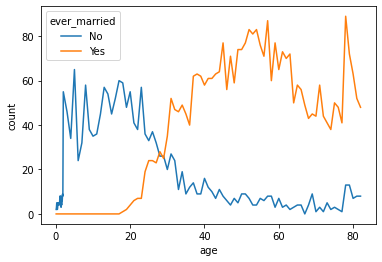

In [35]:
df.groupby(['age', 'ever_married']).size().unstack(fill_value=0).plot(ylabel='count')

Because older people are more likely to get stroke, so we can also find that married people also have a higher proportion of getting stroke.

In [19]:
pd.crosstab(df['ever_married'], df['stroke'], normalize='index').round(2)

stroke,0,1
ever_married,,
No,0.98,0.02
Yes,0.93,0.07


### 2.7 Work Type

In [37]:
df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

From the cross table, we can find that children and people never worked have lower stroke rate.

In [64]:
pd.crosstab(df['work_type'], df['stroke'], normalize='index').round(2)

stroke,0,1
work_type,,
Govt_job,0.949772,0.050228
Never_worked,1.000000,0.000000
Private,0.949042,0.050958
Self-employed,0.920635,0.079365
children,0.997089,0.002911


This is also because of the age. Children and people never worked are all young people with maximum age of 23.

In [63]:
print(f'Max age of "children": {max(df.loc[df["work_type"] == "children", "age"])}')
print(f'Max age of "Never_worked": {max(df.loc[df["work_type"] == "Never_worked", "age"])}')

Max age of "children": 16.0
Max age of "Never_worked": 23.0


### 2.8 Residence Type

There is no significant difference between urban and rural residence to get stroke.

In [67]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [68]:
pd.crosstab(df['Residence_type'], df['stroke'], normalize='index').round(2)

stroke,0,1
Residence_type,,
Rural,0.95,0.05
Urban,0.95,0.05


### 2.9 Average Glucose Level

From the histogram of glucose level, we can find that the majority people have an average glucose level lower than 150. But some people have very high glucose level to about 250.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

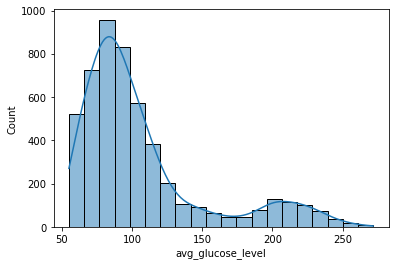

In [69]:
sns.histplot(x='avg_glucose_level', data=df, bins=20, kde=True)

People with higher average glucose level are more likely to get stroke.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Proportion of Stroke'>

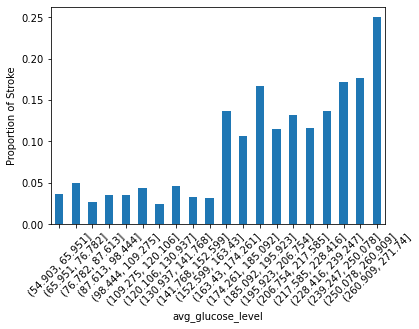

In [77]:
df.groupby(pd.cut(df['avg_glucose_level'], bins=20)).mean()['stroke'].plot.bar(rot=45, ylabel='Proportion of Stroke')

### 2.10 BMI

In [89]:
df[(df['stroke']==1)].shape

(249, 12)